In [0]:
# Needed for functions
import numpy as np
import matplotlib.pyplot as plt
import random

# Import Qiskit classes
import qiskit 
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, IBMQ, execute
from qiskit.providers.aer import noise
from qiskit.quantum_info import state_fidelity
from qiskit.tools.visualization import plot_histogram

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter, MeasurementFilter)

In [0]:
# Load IBMQ account
provider = IBMQ.load_account()

In [0]:
# Generate the calibration circuits
qr = qiskit.QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1], qr=qr, circlabel='mcal')

# Execute the calibration circuits without noise
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()

# The calibration matrix without noise is the identity matrix
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

**Creation of the noise model**

*   Set real_device to 1 and create the noise model from any real device

or

*   Set real_device to 0 and add noise sources manually to the noise model



In [4]:
#Create a noise model from a real device or specified by user? (0=manual, 1=real)
real_device=1

#User-specified noise model
if real_device==0:
   noise_model = noise.NoiseModel()
   device = Aer.get_backend('qasm_simulator')
  
   for qi in range(2):
      read_err = noise.errors.readout_error.ReadoutError([[0.9, 0.1],[0.25,0.75]])
      noise_model.add_readout_error(read_err, [qi])

#Noise model from real device
elif real_device==1:
   #Select backend to extract noise model from
   device = provider.get_backend('ibmqx2')

   #Create noise model
   properties = device.properties()
   coupling_map = device.configuration().coupling_map
   noise_model = noise.device.basic_device_noise_model(properties)
   basis_gates = noise_model.basis_gates

# Execute the calibration circuits using the noise model
backend = qiskit.Aer.get_backend('qasm_simulator')
noisy_job = qiskit.execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
results = noisy_job.result()

# Calculate the calibration matrix
meas_fitter = CompleteMeasFitter(results, state_labels, circlabel='mcal')
meas_filter = meas_fitter.filter

# What is the measurement fidelity?
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

Average Measurement Fidelity: 0.966250


**Setting up the experiment**

The four following parameters can be set before to run the experiment:

*   Simulate noise using the Aer Qasm simulator from the noise model
*   Apply error mitigation (from the noise model) to the computation
*   Run in random mode, reaching any random values of V_k, P_k and C (otherwise experimental angles will be set to compute 13 points reaching all extremal values for V_A, P_A and C
*   Choice of the backend to use for the experiment (has no effect if noise_simulation is set to 1)

Default values are all set to 0, using the Aer Qasm simulator.

You can also specify the path where the data will be registered (.txt files useful for further analysis)

In [0]:
# Simulate noise with the noise model? (the simulator will be used)
noise_simulation=0
# Apply error mitigation from the noise model to the result?
correction=0
# Pick random points? (otherwise 13 points will be selected to reach equally the 1/8 of sphere)
rand=0

backend_1 = provider.get_backend('ibmqx2')
backend_2 = qiskit.Aer.get_backend('qasm_simulator')
# Choose the backend to use
backend = backend_2

# Set path to store data
path="drive/My Drive/Q_VPC/"

Computing point 1, measurement number 0.
Computing point 1, measurement number 1.
Computing point 1, measurement number 2.
Computing point 1, measurement number 3.
Computing point 1, measurement number 4.
Computing point 1, measurement number 5.
Computing point 1, measurement number 6.
Computing point 1, measurement number 7.
Computing point 1, measurement number 8.
Computing point 1, measurement number 9.
Computing point 2, measurement number 0.
Computing point 2, measurement number 1.
Computing point 2, measurement number 2.
Computing point 2, measurement number 3.
Computing point 2, measurement number 4.
Computing point 2, measurement number 5.
Computing point 2, measurement number 6.
Computing point 2, measurement number 7.
Computing point 2, measurement number 8.
Computing point 2, measurement number 9.
Computing point 3, measurement number 0.
Computing point 3, measurement number 1.
Computing point 3, measurement number 2.
Computing point 3, measurement number 3.
Computing point 

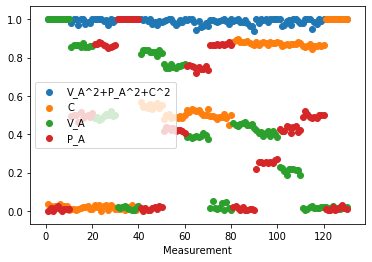

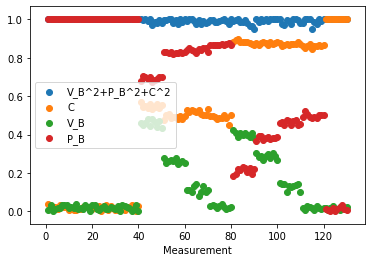

In [6]:
# Create quantum and classical registers
qr = QuantumRegister(2)
cr = ClassicalRegister(2)   

# j = Number of random points on the sphere if random distribution is choosed
# p = number of measurements of each point
if rand==1:
   j=100
   p=1
  
# 13 points of the sphere, with 10 measurements for each point
elif rand==0:
   j=13
   p=10

x_axis=[]
for u in range(1,j*p+1):
  x_axis.append(u)

#Vectors for output data
vec_C=[]
vec_V1a=[]
vec_V1b=[]
vec_V2a=[]
vec_V2b=[]
vec_P1=[]
vec_P2=[]
vec_alpha=[]
vec_theta=[]
circuits=[]

# Loop on the points to be calculated
for m in range(0,j):
   # Loop on measurements to be made for each points, useful to compute errors from the dispersion
   for k in range(0,p):
      print("Computing point "+str(m+1)+", measurement number "+str(k)+".")
      log=open(path+"Quantum_VPC_measurement_"+str(k)+"_point_"+str(m+1)+".txt","w")
      circuit = QuantumCircuit(qr)
      if rand==1:
         theta=random.uniform(0, np.pi)
         alpha=random.uniform(0, np.pi)

      # Parameters giving the 13 combinations (V_A,P_A,C) nicely distributed on the sphere
      elif rand==0:
         if m==0:
            alpha=np.pi/4
            theta=0
         if m==1:
            alpha=0.523599
            theta=np.pi/2+np.pi/2
         if m==2:
            alpha=0.261825
            theta=np.pi/2+np.pi/2
         if m==3:
            alpha=0
            theta=0+np.pi/2
         if m==4:
            alpha=np.pi/4
            theta=0.9817+np.pi/2
         if m==5:
            alpha=0.561489
            theta=0.989+np.pi/2
         if m==6:
            alpha=0.361367
            theta=0.65+np.pi/2
         if m==7:
            alpha=0.261825
            theta=0+np.pi/2
         if m==8:
            alpha=np.pi/4
            theta=0.47+np.pi/2
         if m==9:
            alpha=0.659058
            theta=0.43+np.pi/2
         if m==10:
            alpha=0.561489
            theta=0.24+np.pi/2
         if m==11:
            alpha=0.523599
            theta=0+np.pi/2
         if m==12:
            alpha=np.pi/4
            theta=np.pi/2

      vec_alpha.append(alpha)
      vec_theta.append(theta)
      
      #Add gates to the circuit
      circuit.u3(alpha*2,0,0,qr[0])
      circuit.cu3(theta*2,0,0,qr[0],qr[1])
                
      #Tomography step
      qst_VDC = state_tomography_circuits(circuit,[qr[0], qr[1]])
  
      if noise_simulation==1:
         job = execute(qst_VDC, simulator, noise_model=noise_model,coupling_map=coupling_map,basis_gates=basis_gates)
      elif noise_simulation==0:
         job = execute(qst_VDC, backend, shots=1000)
      
      results=job.result()
      res=results
   
      if correction==1:
         mitigated_results = meas_filter.apply(results)
         res=mitigated_results
      
      tomo_VDC = StateTomographyFitter(res, qst_VDC)

      # Computing the density matrix of the system
      rho = tomo_VDC.fit()
   
      # Change the order of basis vectors for convenience
      rho_copy=rho.copy()
      rho[1][0]=rho_copy[2][0]
      rho[1][1]=rho_copy[2][1]
      rho[1][2]=rho_copy[2][2]
      rho[1][3]=rho_copy[2][3]

      rho[2][0]=rho_copy[1][0]
      rho[2][1]=rho_copy[1][1]
      rho[2][2]=rho_copy[1][2]
      rho[2][3]=rho_copy[1][3]
  
      rho_copy=rho.copy()
  
      rho[0][1]=rho_copy[0][2]
      rho[1][1]=rho_copy[1][2]
      rho[2][1]=rho_copy[2][2]
      rho[3][1]=rho_copy[3][2]
      rho[0][2]=rho_copy[0][1]
      rho[1][2]=rho_copy[1][1]
      rho[2][2]=rho_copy[2][1]
      rho[3][2]=rho_copy[3][1]

      # Compute partial traces
      n1, n2, n=2, 2, 4
      rho_tensor=rho.reshape([n1, n2, n1, n2]);
      rho_a=np.trace(rho_tensor, axis1=1, axis2=3)
      rho_b=np.trace(rho_tensor, axis1=0, axis2=2)

      # Compute V_k, P_k (note that V1a = V1b = V_A because the density matrix is hermitic. Also, we note P1 = P_A, P2 = P_B)
      V1a=2*abs(rho_a[0][1])
      V2a=2*abs(rho_b[0][1])
      V1b=2*abs(rho_a[1][0])
      V2b=2*abs(rho_b[1][0])
      P1=abs(rho_a[1][1]-rho_a[0][0])
      P2=abs(rho_b[1][1]-rho_b[0][0])

      # Compute C
      Sigma = np.array([[0, 0, 0, -1], [0, 0, 1, 0], [0, 1, 0, 0], [-1, 0, 0, 0]])
      rho_transpose = np.transpose(rho)
      V_p_rho=np.linalg.eigvals(rho)
      R = (rho.dot(Sigma)).dot(rho_transpose.dot(Sigma))
      V_p=np.linalg.eigvals(R)
      V_p.sort()
      arg1=0
      arg2=np.sqrt(float(abs(V_p[3])))-np.sqrt(float(abs(V_p[2])))-np.sqrt(float(abs(V_p[1])))-np.sqrt(float(abs(V_p[0])))
      C=max(arg1,arg2)
   
      # Put results in vectors
      vec_C.append(C)
      vec_V1a.append(V1a)
      vec_V1b.append(V1b)
      vec_V2a.append(V2a)
      vec_V2b.append(V2b)
      vec_P1.append(P1)
      vec_P2.append(P2)
    
      # Output string data
      string = str(alpha) + ' ' +str(theta) + ' ' +str(V1a) + ' ' +str(P1)+ ' '+str(V2a)+' '+str(P2)+' '+str(C)
      log.write(string)
      log.close()

# Raw plots of the quantities V_k, P_k, C, and V_k^2+P_k^2+C^2
if rand==0: 
   vector_V2P2C2_1=[]
   vector_V2P2C2_2=[]

   for i in range(0,j*p):
      vector_V2P2C2_1.append(vec_V1a[i]*vec_V1a[i]+vec_P1[i]*vec_P1[i]+vec_C[i]*vec_C[i])
      vector_V2P2C2_2.append(vec_V2a[i]*vec_V2a[i]+vec_P2[i]*vec_P2[i]+vec_C[i]*vec_C[i])

   # Plots
   plt.figure(figsize=(6, 4))
   plt.scatter(x_axis, vector_V2P2C2_1, label='V_A^2+P_A^2+C^2')
   plt.scatter(x_axis, vec_C, label='C')
   plt.scatter(x_axis, vec_V1a, label='V_A')
   plt.scatter(x_axis, vec_P1, label='P_A')
   plt.legend(loc='best')
   plt.xlabel('Measurement')
   plt.ylabel('')
   plt.show()

   plt.figure(figsize=(6, 4))
   plt.scatter(x_axis, vector_V2P2C2_2, label='V_B^2+P_B^2+C^2')
   plt.scatter(x_axis, vec_C, label='C')
   plt.scatter(x_axis, vec_V2a, label='V_B')
   plt.scatter(x_axis, vec_P2, label='P_B')
   plt.legend(loc='best')
   plt.xlabel('Measurement')
   plt.ylabel('')
   plt.show()